In [14]:
# Install dependencies
!pip install tensorflow tensorflow-hub librosa pandas tqdm

# Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from tqdm import tqdm


In [15]:
# Clone ESC-50
!git clone https://github.com/karoldvl/ESC-50.git

# Load metadata
meta_df = pd.read_csv('ESC-50/meta/esc50.csv')
meta_df.head()


fatal: destination path 'ESC-50' already exists and is not an empty directory.


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [21]:
# Load YAMNet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Function to extract embedding from audio
def extract_yamnet_embedding(wav_file):
    waveform, sr = librosa.load(wav_file, sr=16000)  # YAMNet requires 16kHz
    waveform = waveform[:sr*10]  # Limit to 10 seconds if longer
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return tf.reduce_mean(embeddings, axis=0).numpy()


In [22]:
mbeddings = []
labels = []
audio_dir = 'ESC-50/audio/' # Assuming audio files are in this directory relative to the notebook

# Iterate through the metadata and extract embeddings
print("Extracting YAMNet embeddings from audio files...")
# tqdm provides a progress bar, meta_df is the pandas DataFrame loaded earlier
for index, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
    wav_file_path = os.path.join(audio_dir, row['filename'])
    # Check if the audio file exists before processing
    if os.path.exists(wav_file_path):
        try:
            # Call the previously defined function to get the embedding
            embedding = extract_yamnet_embedding(wav_file_path)
            embeddings.append(embedding)
            # Assuming 'category' is the column with labels in meta_df
            labels.append(row['category'])
        except Exception as e:
            # Print an error if a file fails to process but continue with others
            print(f"Error processing file {wav_file_path}: {e}")
    else:
        # Print a warning if a file is not found
        print(f"Warning: File not found {wav_file_path}")

print("Embedding extraction complete.")


Extracting YAMNet embeddings from audio files...


100%|██████████| 2000/2000 [00:35<00:00, 56.81it/s] 

Embedding extraction complete.


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare dataset
X = np.array(embeddings)
y = LabelEncoder().fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Define classifier
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(50, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2468 - loss: 3.5235 - val_accuracy: 0.6250 - val_loss: 1.9320
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6252 - loss: 1.7124 - val_accuracy: 0.7250 - val_loss: 1.2509
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7304 - loss: 1.2271 - val_accuracy: 0.7575 - val_loss: 1.0424
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7622 - loss: 1.0294 - val_accuracy: 0.7600 - val_loss: 0.9569
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7778 - loss: 0.8911 - val_accuracy: 0.7675 - val_loss: 0.8552
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7759 - loss: 0.8160 - val_accuracy: 0.7625 - val_loss: 0.8702
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7927 - loss: 0.7992 - val_accuracy: 0.7525 - val_loss: 0.8407
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8067 - loss: 0.7568 - val_accuracy: 0.7850 - val_loss

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


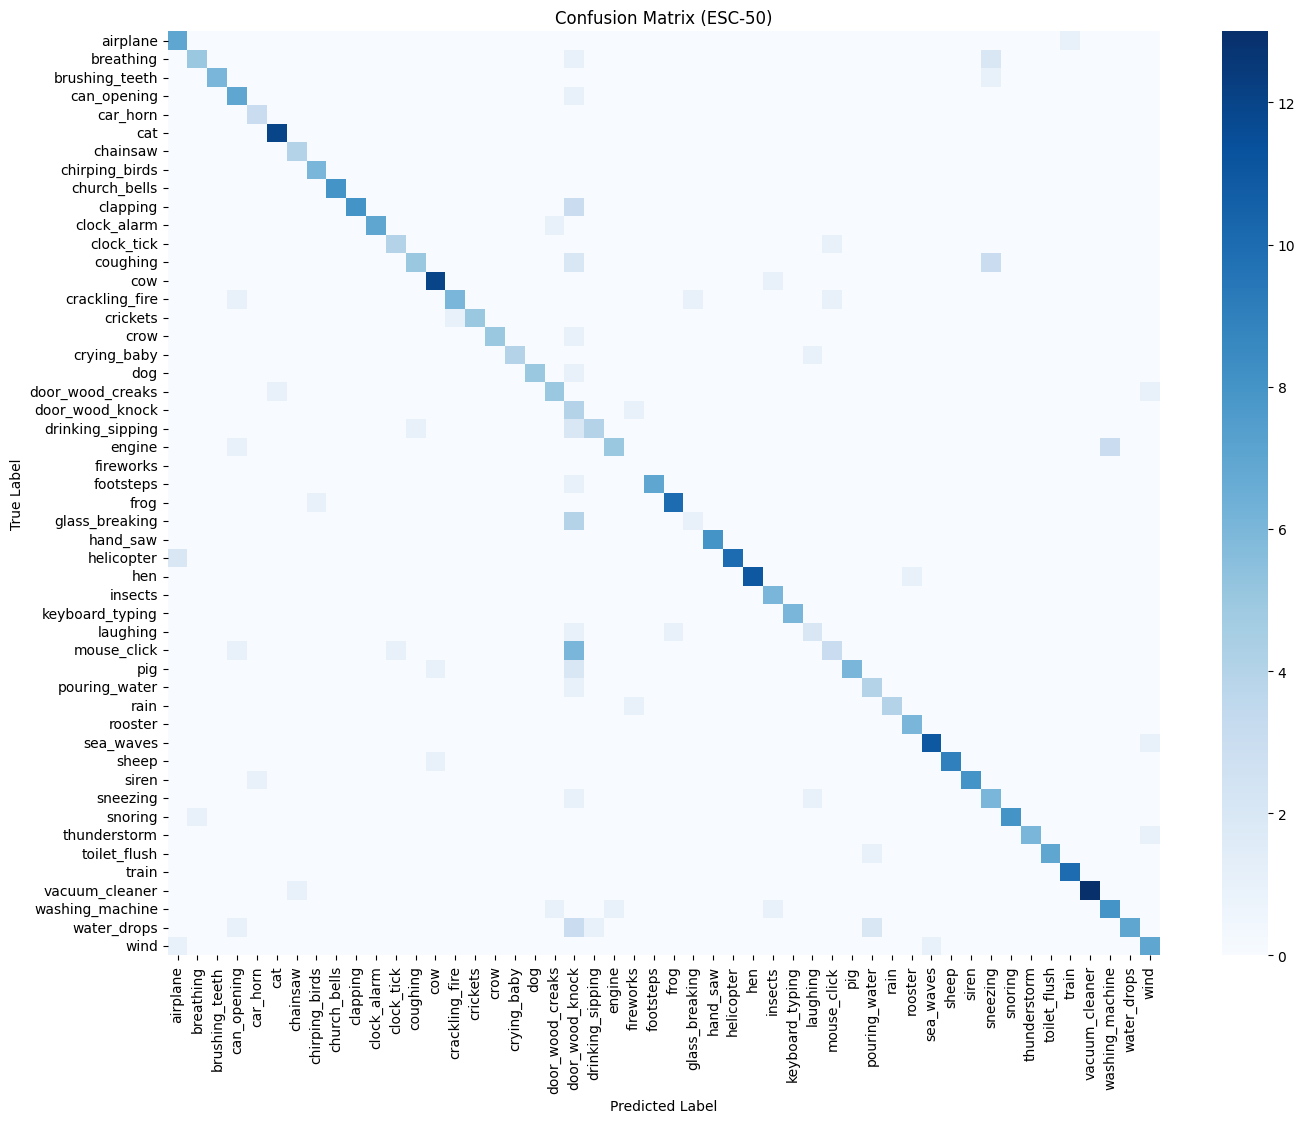

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels
y_pred = model.predict(X_test).argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels_unique = np.unique(labels)

# Plot
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels_unique, yticklabels=labels_unique)
plt.title("Confusion Matrix (ESC-50)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [26]:
# Detailed per-class precision, recall, F1-score
print(classification_report(y_test, y_pred, target_names=np.unique(labels)))


                  precision    recall  f1-score   support

        airplane       0.70      0.88      0.78         8
       breathing       0.83      0.62      0.71         8
  brushing_teeth       1.00      0.86      0.92         7
     can_opening       0.64      0.88      0.74         8
        car_horn       0.75      1.00      0.86         3
             cat       0.92      1.00      0.96        12
        chainsaw       0.80      1.00      0.89         4
  chirping_birds       0.86      1.00      0.92         6
    church_bells       1.00      1.00      1.00         8
        clapping       1.00      0.73      0.84        11
     clock_alarm       1.00      0.88      0.93         8
      clock_tick       0.80      0.80      0.80         5
        coughing       0.83      0.50      0.62        10
             cow       0.86      0.92      0.89        13
  crackling_fire       0.86      0.67      0.75         9
        crickets       1.00      0.83      0.91         6
            c

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
model.save("esc50_yamnet_model.h5") # saved for model real-time classification


# **Real-Time Classification**

In [28]:

!pip install gradio soundfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 138.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import tensorflow_hub as hub
import librosa
import numpy as np
import tensorflow as tf

# Load YAMNet again
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Load your trained classifier
classifier = tf.keras.models.load_model("esc50_yamnet_model.h5")  # Or whatever you named it

# Load your label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)  # Use the same labels list you trained with

# Inference function
def classify_audio(audio):
    waveform, sr = librosa.load(audio, sr=16000)
    waveform = waveform[:sr*10]  # Limit to 10 sec
    scores, embeddings, spectrogram = yamnet_model(waveform)
    embedding = tf.reduce_mean(embeddings, axis=0).numpy()
    prediction = classifier.predict(np.expand_dims(embedding, axis=0)).argmax()
    label = label_encoder.inverse_transform([prediction])[0]
    return label

# Build Gradio interface
# The 'source' argument has been removed and is no longer necessary.
# The 'type' argument should be "filepath" to receive audio data as a temporary file path.
interface = gr.Interface(
    fn=classify_audio,
    inputs=gr.Audio(type="filepath"),  # Changed to gr.Audio(type="filepath")
    outputs="label",
    title="🎧 Real-Time ESC-50 Classifier",
    description="Speak or upload a sound. The model will classify it based on the ESC-50 dataset."
)

# Launch
interface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3b26edb2aaf7bd0de5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
